# **PEML MLP 2**
### Architecture 2 - PINN
With Amsterdam data for transferability

## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a Optuna hyperparameters optimisation and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.

## **IMPORTANT NOTE**: 
- do preprocessing from ``preprocess.ipynb`` to obtain data in ``data/data_combined``, before starting this notebook
- make sure the notebook is under ``src`` directory before running!
- change the global variables defined below for the desired years of data, loss function and NN type



In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *
from modelling.physics import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import pickle

Starting script...

Running __init__.py for data pipeline...


Modelling package initialized



Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [4]:
import importlib
import config
importlib.reload(config)

<module 'config' from '/home/rachel/forecasting_smog_PEML/src/config.py'>

In [5]:
from config import *

In [6]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress


print("BASE_DIR: ", BASE_DIR)
print("MODEL_PATH: ", MODEL_PATH)
print("Results path: ", RESULTS_PATH)

torch.manual_seed(34)             # set seed for reproducibility


BASE_DIR:  /home/rachel/forecasting_smog_PEML
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/models
Results path:  /home/rachel/forecasting_smog_PEML/src/results



## MODIFY THESE GLOBAL VARIABLES FOR YOUR MODEL SCENARIO
all other variables are defined in config.py

LOSS_FUNC: choose from 
- MSE
- LinearShift_MSE
- PDE_nmer_const
- PDE_nmer_piece
- PINN

In [7]:
# Change this according to the data you want to use
YEARS = [2017, 2018, 2020, 2021, 2022, 2023]
TRAIN_YEARS = [2017, 2018, 2020, 2021, 2022]
VAL_YEARS = [2021, 2022, 2023]
TEST_YEARS = [2021, 2022, 2023]

LOSS_FUNC = "PINN"
NN_TYPE = "MLP"

## Automated Generation of paths and filenames according to data years, loss func, NN type
- will be used throughout the whole notebook
- check ``config.py`` for global variables defined outside the notebook

In [8]:
if YEARS == [2017, 2018, 2020, 2021, 2022, 2023]:
    years = "allyears"
    MINMAX_PATH = MINMAX_PATH_ALLYEARS_AMS
    DATASET_PATH = DATASET_PATH_ALLYEARS_AMS
    
    print("Using all years")
    
elif YEARS == [2017]:
    years = "2017"
    MINMAX_PATH = MINMAX_PATH_2017_AMS
    DATASET_PATH = DATASET_PATH_2017_AMS
    print("Using 2017")
else:
    raise ValueError("Invalid years selected")


MODEL_PATH_NAME = f'best_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.pth' #using same model trained on Utrecht
RESULTS_METRICS_FILENAME = f'results_{NN_TYPE}_no2_{LOSS_FUNC}_{years}_Amsterdam.csv' # metrics saved in different file
BESTPARAMS_FILENAME = f'best_params_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.txt' #use same params as Utrecht
PLOT_FILENAME = f'plot_{NN_TYPE}_no2_{LOSS_FUNC}_{years}_Amsterdam.png'
print("MINMAX_PATH: ", MINMAX_PATH)
print("DATASET_PATH: ", DATASET_PATH)
print("MODEL_PATH_NAME: ", MODEL_PATH_NAME)
print("RESULTS_METRICS_FILENAME: ", RESULTS_METRICS_FILENAME)
print("BESTPARAMS_FILENAME: ", BESTPARAMS_FILENAME)
print("PLOT_FILENAME: ", PLOT_FILENAME)

Using all years
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/Amsterdam/all_years/pollutants_minmax_allyears.csv
DATASET_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/Amsterdam/all_years
MODEL_PATH_NAME:  best_MLP_no2_PINN_allyears.pth
RESULTS_METRICS_FILENAME:  results_MLP_no2_PINN_allyears_Amsterdam.csv
BESTPARAMS_FILENAME:  best_params_MLP_no2_PINN_allyears.txt
PLOT_FILENAME:  plot_MLP_no2_PINN_allyears_Amsterdam.png


### **Load in data and create PyTorch *Datasets***

In [9]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS, DATASET_PATH)
train_output_frames = get_dataframes('train', 'y', YEARS, DATASET_PATH)

val_input_frames = get_dataframes('val', 'u', YEARS, DATASET_PATH)
val_output_frames = get_dataframes('val', 'y', YEARS, DATASET_PATH)

test_input_frames = get_dataframes('test', 'u', YEARS, DATASET_PATH)
test_output_frames = get_dataframes('test', 'y', YEARS, DATASET_PATH)

print("Successfully loaded data")

Imported train_2017_combined_u.csv


Imported train_2018_combined_u.csv
Imported train_2020_combined_u.csv
Imported train_2021_combined_u.csv
Imported train_2022_combined_u.csv
Imported train_2017_combined_y.csv
Imported train_2018_combined_y.csv
Imported train_2020_combined_y.csv
Imported train_2021_combined_y.csv
Imported train_2022_combined_y.csv
Imported val_2021_combined_u.csv
Imported val_2022_combined_u.csv
Imported val_2023_combined_u.csv
Imported val_2021_combined_y.csv
Imported val_2022_combined_y.csv
Imported val_2023_combined_y.csv
Imported test_2021_combined_u.csv
Imported test_2022_combined_u.csv
Imported test_2023_combined_u.csv
Imported test_2021_combined_y.csv
Imported test_2022_combined_y.csv
Imported test_2023_combined_y.csv
Successfully loaded data


In [10]:
train_input_frames

[                           DD        FF        FH        FX  NO2_HAARLEM  \
 DateTime                                                                   
 2017-08-01 00:00:00  0.333333  0.111111  0.058824  0.076923     0.142376   
 2017-08-01 01:00:00  0.000000  0.000000  0.058824  0.076923     0.145409   
 2017-08-01 02:00:00  0.472222  0.055556  0.058824  0.076923     0.145409   
 2017-08-01 03:00:00  0.361111  0.055556  0.058824  0.038462     0.135636   
 2017-08-01 04:00:00  0.527778  0.055556  0.058824  0.076923     0.181045   
 ...                       ...       ...       ...       ...          ...   
 2017-12-30 19:00:00  0.694444  0.500000  0.529412  0.500000     0.102359   
 2017-12-30 20:00:00  0.694444  0.444444  0.529412  0.500000     0.096799   
 2017-12-30 21:00:00  0.694444  0.444444  0.470588  0.461538     0.111879   
 2017-12-30 22:00:00  0.694444  0.388889  0.470588  0.461538     0.119377   
 2017-12-30 23:00:00  0.638889  0.333333  0.411765  0.423077     0.106655   

In [11]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

In [12]:
train_dataset.u

[                           DD        FF        FH        FX  NO2_HAARLEM  \
 DateTime                                                                   
 2017-08-01 00:00:00  0.333333  0.111111  0.058824  0.076923     0.142376   
 2017-08-01 01:00:00  0.000000  0.000000  0.058824  0.076923     0.145409   
 2017-08-01 02:00:00  0.472222  0.055556  0.058824  0.076923     0.145409   
 2017-08-01 03:00:00  0.361111  0.055556  0.058824  0.038462     0.135636   
 2017-08-01 04:00:00  0.527778  0.055556  0.058824  0.076923     0.181045   
 ...                       ...       ...       ...       ...          ...   
 2017-12-30 19:00:00  0.694444  0.500000  0.529412  0.500000     0.102359   
 2017-12-30 20:00:00  0.694444  0.444444  0.529412  0.500000     0.096799   
 2017-12-30 21:00:00  0.694444  0.444444  0.470588  0.461538     0.111879   
 2017-12-30 22:00:00  0.694444  0.388889  0.470588  0.461538     0.119377   
 2017-12-30 23:00:00  0.638889  0.333333  0.411765  0.423077     0.106655   

In [13]:
train_dataset.y

[                          NO2
 DateTime                     
 2017-08-01 00:00:00  0.142376
 2017-08-01 01:00:00  0.145409
 2017-08-01 02:00:00  0.145409
 2017-08-01 03:00:00  0.135636
 2017-08-01 04:00:00  0.181045
 ...                       ...
 2017-12-30 19:00:00  0.102359
 2017-12-30 20:00:00  0.096799
 2017-12-30 21:00:00  0.111879
 2017-12-30 22:00:00  0.119377
 2017-12-30 23:00:00  0.106655
 
 [3648 rows x 1 columns],
                           NO2
 DateTime                     
 2018-08-01 00:00:00  0.215501
 2018-08-01 01:00:00  0.199073
 2018-08-01 02:00:00  0.206487
 2018-08-01 03:00:00  0.237489
 2018-08-01 04:00:00  0.259646
 ...                       ...
 2018-12-30 19:00:00  0.167818
 2018-12-30 20:00:00  0.169840
 2018-12-30 21:00:00  0.177422
 2018-12-30 22:00:00  0.128728
 2018-12-30 23:00:00  0.116007
 
 [3648 rows x 1 columns],
                           NO2
 DateTime                     
 2020-08-01 00:00:00  0.131003
 2020-08-01 01:00:00  0.143302
 2020-08-01 02

In [14]:
len(train_dataset.pairs[0][0])

72

In [15]:
train_dataset.pairs[0][0]

tensor([[0.3333, 0.1111, 0.0588, 0.0769, 0.1424, 0.2460, 0.6370, 0.0000, 0.5239,
         0.7348],
        [0.0000, 0.0000, 0.0588, 0.0769, 0.1454, 0.2738, 0.6427, 0.0000, 0.4920,
         0.7348],
        [0.4722, 0.0556, 0.0588, 0.0769, 0.1454, 0.2797, 0.6384, 0.0000, 0.4894,
         0.7348],
        [0.3611, 0.0556, 0.0588, 0.0385, 0.1356, 0.2190, 0.6370, 0.0000, 0.4521,
         0.6894],
        [0.5278, 0.0556, 0.0588, 0.0769, 0.1810, 0.2536, 0.6370, 0.0000, 0.4894,
         0.7386],
        [0.5556, 0.1111, 0.1176, 0.1154, 0.2842, 0.2460, 0.6398, 0.0000, 0.5665,
         0.7917],
        [0.6667, 0.2778, 0.2353, 0.2308, 0.3099, 0.2567, 0.6525, 0.2000, 0.5957,
         0.7727],
        [0.7222, 0.2222, 0.2353, 0.2308, 0.3334, 0.2673, 0.6525, 0.0000, 0.5984,
         0.7652],
        [0.6667, 0.2222, 0.2353, 0.2308, 0.2260, 0.2780, 0.6554, 0.0000, 0.6037,
         0.7538],
        [0.7222, 0.2222, 0.2353, 0.2692, 0.2384, 0.1811, 0.6582, 0.4000, 0.6543,
         0.7538],
        [0

In [16]:
train_dataset.pairs[0][1]

tensor([[0.1263],
        [0.1147],
        [0.1055],
        [0.1324],
        [0.1792],
        [0.2374],
        [0.2677],
        [0.2115],
        [0.1690],
        [0.1104],
        [0.1179],
        [0.0981],
        [0.0767],
        [0.1024],
        [0.0686],
        [0.0797],
        [0.0473],
        [0.0460],
        [0.0428],
        [0.0389],
        [0.0452],
        [0.0406],
        [0.0350],
        [0.0478]])

## Confirmation that the dataset has column indexes the same as those in ``config.py``
Indexes are used mainly for the physics calculations, in order to accurately extract the information needed

In [17]:
# Assuming train_dataset.u[0] is a pandas Index object with column names
column_names = list(train_dataset.u[0])  # Convert Index to list


print("No2 Oudemeer idx: ", column_names.index('NO2_OUDEMEER'))
print("No2 Haarlem idx: ", column_names.index('NO2_HAARLEM'))
print("wind dir (dd) idx: ", column_names.index('DD'))
print("wind speed (fh) idx: ", column_names.index('FH'))

# check if the indices are the same as whats defined in config.py
assert column_names.index('NO2_OUDEMEER')== NO2_OUDEMEER_IDX
assert column_names.index('NO2_HAARLEM') == NO2_HAARLEM_IDX
assert column_names.index('DD') == WIND_DIR_IDX
assert column_names.index('FH') == WIND_SPEED_IDX
print("Column indices are same as config.py")



No2 Oudemeer idx:  5
No2 Haarlem idx:  4
wind dir (dd) idx:  0
wind speed (fh) idx:  2
Column indices are same as config.py


In [18]:
train_dataset.u[0].iloc[:,NO2_TUINDORP_IDX]

DateTime
2017-08-01 00:00:00    0.245998
2017-08-01 01:00:00    0.273799
2017-08-01 02:00:00    0.279697
2017-08-01 03:00:00    0.219040
2017-08-01 04:00:00    0.253580
                         ...   
2017-12-30 19:00:00    0.072452
2017-12-30 20:00:00    0.084246
2017-12-30 21:00:00    0.114575
2017-12-30 22:00:00    0.090143
2017-12-30 23:00:00    0.090143
Name: NO2_OUDEMEER, Length: 3648, dtype: float64

In [19]:
train_dataset.u[0].iloc[:,NO2_BREUKELEN_IDX]

DateTime
2017-08-01 00:00:00    0.142376
2017-08-01 01:00:00    0.145409
2017-08-01 02:00:00    0.145409
2017-08-01 03:00:00    0.135636
2017-08-01 04:00:00    0.181045
                         ...   
2017-12-30 19:00:00    0.102359
2017-12-30 20:00:00    0.096799
2017-12-30 21:00:00    0.111879
2017-12-30 22:00:00    0.119377
2017-12-30 23:00:00    0.106655
Name: NO2_HAARLEM, Length: 3648, dtype: float64

In [20]:
train_dataset.u[0].iloc[:,WIND_DIR_IDX]

DateTime
2017-08-01 00:00:00    0.333333
2017-08-01 01:00:00    0.000000
2017-08-01 02:00:00    0.472222
2017-08-01 03:00:00    0.361111
2017-08-01 04:00:00    0.527778
                         ...   
2017-12-30 19:00:00    0.694444
2017-12-30 20:00:00    0.694444
2017-12-30 21:00:00    0.694444
2017-12-30 22:00:00    0.694444
2017-12-30 23:00:00    0.638889
Name: DD, Length: 3648, dtype: float64

In [21]:
train_dataset.u[0].iloc[:,WIND_SPEED_IDX]

DateTime
2017-08-01 00:00:00    0.058824
2017-08-01 01:00:00    0.058824
2017-08-01 02:00:00    0.058824
2017-08-01 03:00:00    0.058824
2017-08-01 04:00:00    0.058824
                         ...   
2017-12-30 19:00:00    0.529412
2017-12-30 20:00:00    0.529412
2017-12-30 21:00:00    0.470588
2017-12-30 22:00:00    0.470588
2017-12-30 23:00:00    0.411765
Name: FH, Length: 3648, dtype: float64

## Tuning Hyperparameters with Optuna

In [22]:
print("tuning with loss function: ", LOSS_FUNC)
print("tuning with nn type: ", NN_TYPE)

tuning with loss function:  PINN
tuning with nn type:  MLP


In [23]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Save the params to a file
Parameters saved in ``src/results/best_params/best_params_MLP_no2_PINN_allyears.txt``

In [24]:
import json
best_params_file_path = f"{RESULTS_PATH}/best_params/{BESTPARAMS_FILENAME}"

## Read params from file

In [25]:
with open(best_params_file_path, "r") as f:
    best_params = json.load(f)  # Automatically converts it to a dictionary

print("Loaded Best Parameters:", best_params)


Loaded Best Parameters: {'n_hidden_layers': 5, 'n_hidden_units': 110, 'lr': 5.000010089761398e-05, 'weight_decay': 1.2857958559390203e-07, 'lambda_phy': 0.0026498140983581076, 'batch_size': 16}


In [26]:
set_seed(42)
# Train the model with the best hyperparameters
best_model = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function=LOSS_FUNC,
)
# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)


## Test and Save Results
Results saved in ``src/results/metrics/results_MLP_no2_PINN_allyears.csv``

In [27]:
best_model.load_state_dict(torch.load(f"{MODEL_PATH}/{MODEL_PATH_NAME}", map_location=device))
best_model.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse, smape, inference_time = best_model.test_model(test_loader, min_value=min_value, max_value=max_value, device=device)



Test MSE Loss: 85.029214
Test RMSE Loss: 8.008382
Test SMAPE Loss: 36.464833%
Total Inference Time: 0.15 seconds


In [28]:
import csv

# Define the CSV file path
results_csv_path = f"{RESULTS_PATH}/transferability/{RESULTS_METRICS_FILENAME}"

# Save metrics in a proper CSV format (header + values in one row)
with open(results_csv_path, mode="w", newline="") as f:
    writer = csv.writer(f)
    
    # Write header
    writer.writerow(["MSE", "RMSE", "SMAPE", "Inference Time"])
    
    # Write values
    writer.writerow([mse, rmse, smape, inference_time])

print(f"Results saved as {RESULTS_METRICS_FILENAME} in transferability folder")

Results saved as results_MLP_no2_PINN_allyears_Amsterdam.csv in transferability folder


## Plot Model predictions vs True values
Plot saved ``src/results/plots/plot_MLP_no2_PINN_allyears.png``

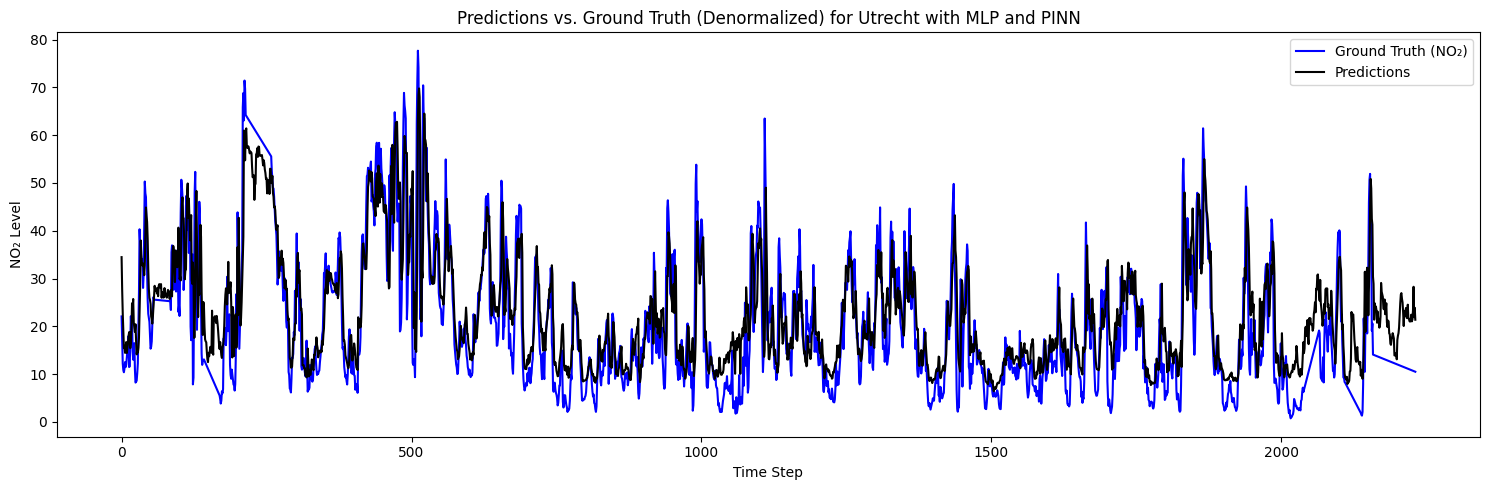

In [30]:
import torch 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load min and max values for denormalization
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = torch.tensor(df_minmax["min"].values, dtype=torch.float32)  # shape: (N_OUTPUT_UNITS,)
max_value = torch.tensor(df_minmax["max"].values, dtype=torch.float32)  # shape: (N_OUTPUT_UNITS,)

# Dynamically detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure model is on the right device and in eval mode
best_model.to(device)
best_model.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch
        x_test = x_test.to(device)
        y_true = y_true.to(device)

        # Get predictions
        y_pred = best_model(x_test)

        # Move to CPU and store
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Stack batches
y_preds = torch.cat(y_preds, dim=0)  # shape: (batch_size, n_hours_y, n_outputs)
y_trues = torch.cat(y_trues, dim=0)

# Denormalize
min_value = min_value.unsqueeze(0).unsqueeze(0)  # shape: (1, 1, n_outputs)
max_value = max_value.unsqueeze(0).unsqueeze(0)
y_preds_denorm = y_preds * (max_value - min_value) + min_value
y_trues_denorm = y_trues * (max_value - min_value) + min_value

# Convert to numpy for plotting
y_preds_np = y_preds_denorm.numpy()
y_trues_np = y_trues_denorm.numpy()

# Plot 1 feature/channel (e.g., station 0)
feature_idx = 0
plt.figure(figsize=(15, 5))
plt.plot(y_trues_np[:, :, feature_idx].flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.plot(y_preds_np[:, :, feature_idx].flatten(), label="Predictions", linestyle="-", color="black")

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title(f"Predictions vs. Ground Truth (Denormalized) for Utrecht with {NN_TYPE} and {LOSS_FUNC}")
plt.legend()
plt.tight_layout()
# Save the plot
plt.savefig(f"{RESULTS_PATH}/transferability/{PLOT_FILENAME}")
plt.show()
